# Итоговая работа

In [80]:
from sklearn.datasets import load_boston

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

import math

import itertools as it

Чек-лист:
1. Загрузите датасет taxi.csv.
2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.
4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

In [81]:
data = pd.read_csv('taxi.csv')

In [82]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


#### Описание датасета
- offer_gk – unique offer identifier
- weekday_key – day of week number (Sunday = 0, Monday = 1, etc.)
- hour_key – hour of day representing an hour part of datetime (value from 0 to 23)
- driver_gk – unique driver identifier
- order_gk – unique order identifier. Order may have multiple offers
- driver_latitude – latitude of driver at the time of getting an offer 
- driver_longitude – longitude of driver at the time of receiving an offer
- origin_order_latitude – latitude of the order start location at the time of receiving an offer
- origin_order_longitude – longitude of the order start location at the moment of receiving an offer
- distance_km – estimated distance from origin to destination in kilometres. Value -1 means that the - destination is not set
- duration_min – estimated duration from origin to destination in minutes. Value -1 means that the destination is not set
- offer_class_group – class of the order, e.g. Economy, Business, XL
- ride_type_desc – private or business order attribute
- driver_response – driver choice of whether to accept the offer or not

In [83]:
data.shape

(100000, 14)

In [84]:
data[['weekday_key', 'hour_key', 'distance_km', 'duration_min', 'driver_response']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekday_key,100000.0,3.159860,2.054222,0.0,1.0,3.0000,5.00000,6.000
hour_key,100000.0,13.827790,7.306496,0.0,8.0,16.0000,20.00000,23.000
distance_km,100000.0,18.393518,41.129296,-1.0,-1.0,10.4115,30.66525,5234.283
duration_min,100000.0,23.134841,33.890105,-1.0,-1.0,19.7000,37.86700,3958.283
driver_response,100000.0,0.492480,0.499946,0.0,0.0,0.0000,1.00000,1.000


In [85]:
data['offer_class_group'].value_counts()

Economy     48335
Standard    47288
Premium      1773
Delivery     1290
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

In [86]:
data['ride_type_desc'].value_counts()

private      91207
business      8533
affiliate      224
SMB             36
Name: ride_type_desc, dtype: int64

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [88]:
data.isnull().sum()

offer_gk                  0
weekday_key               0
hour_key                  0
driver_gk                 0
order_gk                  0
driver_latitude           0
driver_longitude          0
origin_order_latitude     0
origin_order_longitude    0
distance_km               0
duration_min              0
offer_class_group         0
ride_type_desc            0
driver_response           0
dtype: int64

#### Описание наблюдений:
- датасет представляет собой данные по заказам такси
- всего есть информация по 100 тыс. заказов такси, по каждому из них есть 14 признаков, в том числе 3 признака - идентификатора поездки/заказа/водителя
- есть много категориальных признаков, такие как дни недели, часы заказа, класс и тип поездки. Дни недели и часы можно будет преобразовать в несколько признаков: будни/выходные, день/ночь/вечер. Параметры класс и тип поездки так же разделить на отдельные параметры, которые будут принимать только два значения
- есть информация о предполагаемой длительности поездки и дистанции до пункта назначения, но о дистанции между клиентом и таксистом можно судить только по координатам. Соответственно можно вычислить расстояния между ними и попытаться вычислить примерное время в пути до клиента
- есть заказы без определенного места назначения. Возможно их придется выделить в отдельный параметр
- пропусков нет, но есть странные значения, которые возможно нужно будет исключить после проверки. Например, дистанция поездки более 5 тыс. км, или класс поездки "test"

Разберемся с показателем distance_km

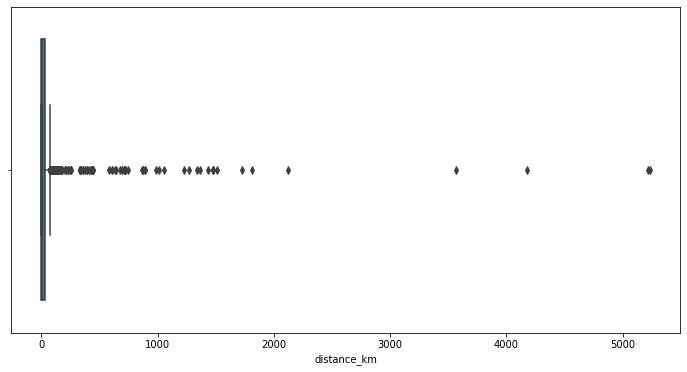

In [89]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data.distance_km)
plt.show()

In [90]:
data[(data['distance_km'] > 80) | ((data['distance_km'] >= 0) & (data['distance_km'] < 1))].shape

(1164, 14)

Есть выбросы с дистанцией поездки больше 80 км, что для городского такси выглядит странно. И с дистанцией поездки менее 1 км. Всего там 1164 значений. Предлагается их исключить.

In [91]:
data = data[data['distance_km'] <= 80]

In [92]:
data = data.loc[~((data['distance_km'] >= 0) & (data['distance_km'] < 1))]

In [93]:
data.shape

(98836, 14)

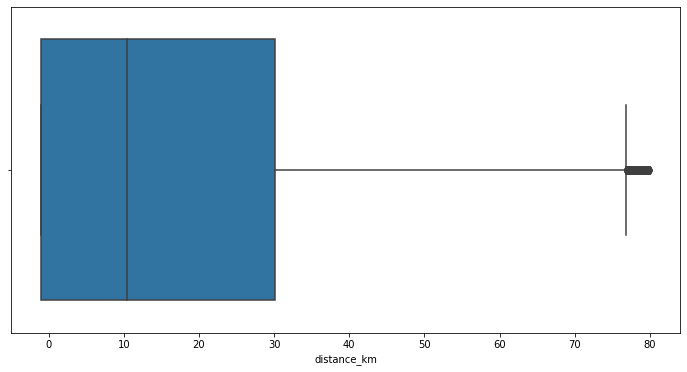

In [94]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data.distance_km)
plt.show()

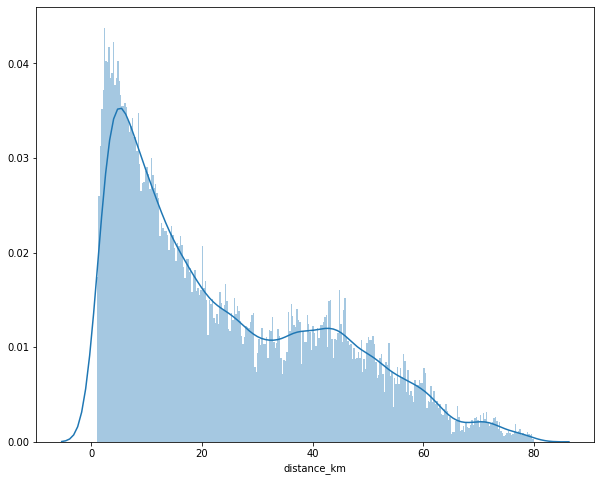

In [95]:
plt.figure(figsize = (10,8))
sns.distplot(data[data['distance_km']>0]['distance_km'], bins=300)
plt.show()

Существует много заказов с неопределенной дальностью поездки. Их исключать нельзя, но предлагается добавить их в отдельный признак

In [96]:
data.loc[data['distance_km']<0, 'dist_unknown'] = 1
data.loc[data['distance_km']>0, 'dist_unknown'] = 0

Добавим расстояние между водителем и клиентом во время поступления заказа. Для этого создадим функцию, которая будет вычислять расстояние по координатам двух точек

In [97]:
def dist(row):
    R = 6373.0

    lat1 = math.radians(row['driver_latitude'])
    lon1 = math.radians(row['driver_longitude'])
    lat2 = math.radians(row['origin_order_latitude'])
    lon2 = math.radians(row['origin_order_longitude'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

Применим функцию для датасета

In [98]:
data['dist_driver_order'] = data.apply(dist, axis=1) 

In [99]:
data[['dist_driver_order']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dist_driver_order,98836.0,11.841057,279.300064,0.0,0.404461,0.655852,1.323045,7278.687387


Посмотрим на распределение заказов по расстоянию между клиентом и водителем

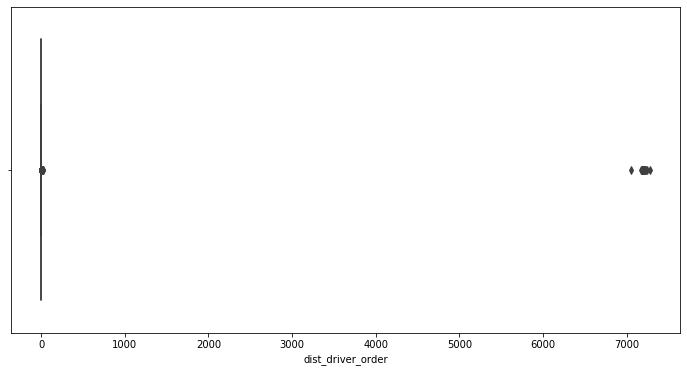

In [100]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data.dist_driver_order)
plt.show()

После добавления дополнительного параметра сразу заметны выбросы, посмотрим на них, и при необходимости исключим.

In [101]:
data[data['dist_driver_order']>=8].shape

(165, 16)

Всего 165 заказа с расстоянием 10 и более км между водителем и клиентом. Опять таки для городского такси это выглядит ненормально. Предлагается их исключить.

In [102]:
data = data[data['dist_driver_order']<8]

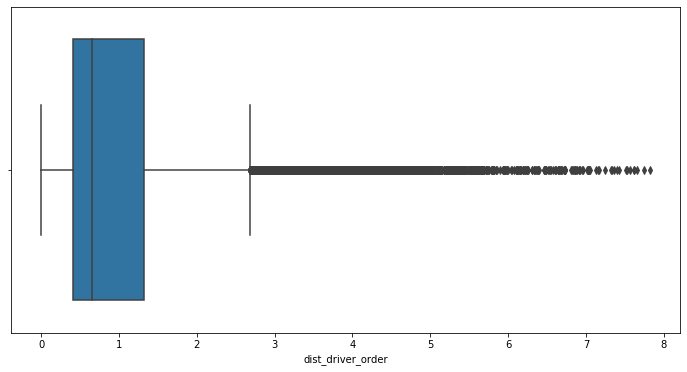

In [103]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data.dist_driver_order)
plt.show()

In [104]:
data.shape

(98671, 16)

Так как столбцы с координатами больше ненужны, удаляем их

In [105]:
data.drop(['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'], axis=1, inplace = True)

In [106]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dist_unknown,dist_driver_order
0,1105373,5,20,6080,174182,-1.000,-1.000,Economy,private,0,1.0,1.363473
1,759733,5,14,6080,358774,18.802,25.217,Standard,private,1,0.0,3.414164
2,416977,6,14,6080,866260,6.747,9.800,Economy,private,0,0.0,0.410128
3,889660,2,6,6080,163522,-1.000,-1.000,Economy,private,1,1.0,0.647676
4,1120055,4,16,6080,506710,12.383,19.250,Economy,private,1,0.0,1.062815


Также добавим параметр ориентировочного времени от водителя до клиента. Для тех поездок, по которым известно расстояние и время, вычислим из имеющихся данных, для прочих поездок, вычислим среднюю скорость для каждого часа каждого дня недели, и на основе полученных данных вычислим время

In [107]:
data_1 = data[data['distance_km']>0]

In [108]:
data_1.shape

(72592, 12)

In [109]:
speed = pd.pivot_table(data_1, 
               index = ['weekday_key', 'hour_key'], 
               values = ['distance_km', 'duration_min'],
               aggfunc = ('mean')).reset_index()

In [110]:
speed['speed'] = speed['distance_km'] / speed['duration_min']

In [111]:
speed.drop(['distance_km', 'duration_min'], axis=1, inplace = True)

In [112]:
data = data.merge(speed, how = 'left', on = ['weekday_key', 'hour_key'])

In [113]:
data.loc[data['distance_km']>0, 'dur_driver_order'] = data['dist_driver_order'] / (data['distance_km'] / data['duration_min'])
data.loc[data['distance_km']<0, 'dur_driver_order'] = data['dist_driver_order'] / data['speed']

In [114]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dist_unknown,dist_driver_order,speed,dur_driver_order
0,1105373,5,20,6080,174182,-1.000,-1.000,Economy,private,0,1.0,1.363473,0.750471,1.816823
1,759733,5,14,6080,358774,18.802,25.217,Standard,private,1,0.0,3.414164,0.664303,4.579032
2,416977,6,14,6080,866260,6.747,9.800,Economy,private,0,0.0,0.410128,0.716270,0.595710
3,889660,2,6,6080,163522,-1.000,-1.000,Economy,private,1,1.0,0.647676,0.878453,0.737291
4,1120055,4,16,6080,506710,12.383,19.250,Economy,private,1,0.0,1.062815,0.715690,1.652200


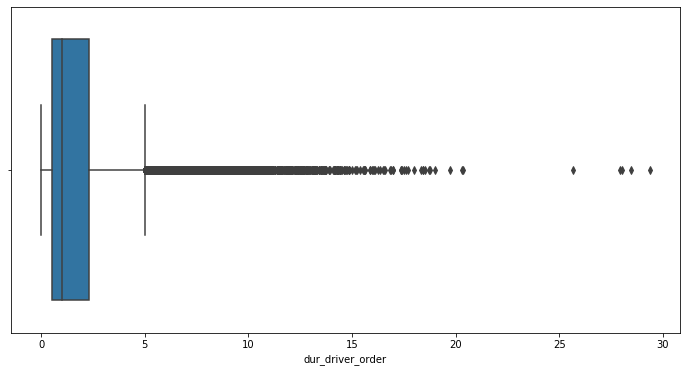

In [115]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data.dur_driver_order)
plt.show()

In [116]:
data[data['dur_driver_order']>15].shape

(46, 14)

In [117]:
data = data[data['dur_driver_order']<=15]

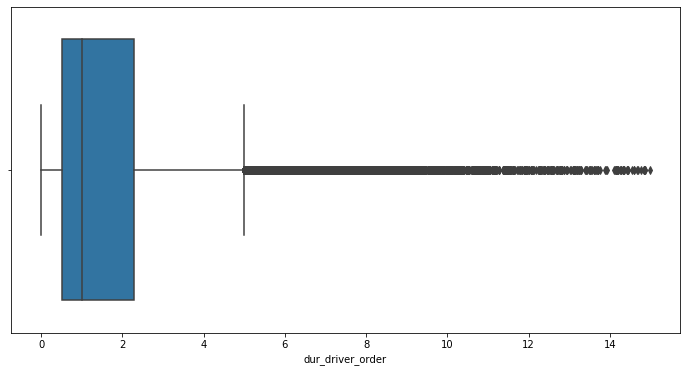

In [118]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data.dur_driver_order)
plt.show()

Так как поездки с неопределенным расстоянием мы вынесли в отдельный признак, предлагается заполнить расстояние и длительность медианой по классу и типу поездки.

In [119]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dist_unknown,dist_driver_order,speed,dur_driver_order
0,1105373,5,20,6080,174182,-1.000,-1.000,Economy,private,0,1.0,1.363473,0.750471,1.816823
1,759733,5,14,6080,358774,18.802,25.217,Standard,private,1,0.0,3.414164,0.664303,4.579032
2,416977,6,14,6080,866260,6.747,9.800,Economy,private,0,0.0,0.410128,0.716270,0.595710
3,889660,2,6,6080,163522,-1.000,-1.000,Economy,private,1,1.0,0.647676,0.878453,0.737291
4,1120055,4,16,6080,506710,12.383,19.250,Economy,private,1,0.0,1.062815,0.715690,1.652200


In [120]:
data[data['dist_unknown']==0]['distance_km'].sum()

1742609.3900000001

In [121]:
median_dist = pd.pivot_table(data_1, 
               index = ['offer_class_group', 'ride_type_desc'], 
               values = ['distance_km', 'duration_min'],
               aggfunc = ('median')).reset_index()
median_dist

,offer_class_group,ride_type_desc,distance_km,duration_min
0,Delivery,business,16.4090,30.1500
1,Delivery,private,14.3040,25.5085
2,Economy,SMB,23.2700,26.4330
3,Economy,business,14.8090,26.0330
4,Economy,private,17.2985,26.6330
5,Kids,private,8.9790,18.4670
6,Premium,private,10.5060,21.1670
7,Standard,business,17.0830,26.3670
8,Standard,private,23.3780,31.6500
9,VIP,private,7.6485,19.0170


In [122]:
data = data.merge(median_dist, how = 'left', on = ['offer_class_group', 'ride_type_desc'])

In [123]:
data.loc[data['distance_km_x']<0, 'distance_km_x'] = data['distance_km_y']
data.loc[data['duration_min_x']<0, 'duration_min_x'] = data['distance_km_x'] / data['speed']

In [124]:
data.drop(['distance_km_y', 'duration_min_y'], axis=1, inplace = True)

In [125]:
data.rename(columns={'distance_km_x': 'distance_km', 'duration_min_x': 'duration_min'}, inplace=True)

In [126]:
data.isnull().sum()

offer_gk               0
weekday_key            0
hour_key               0
driver_gk              0
order_gk               0
distance_km          368
duration_min         368
offer_class_group      0
ride_type_desc         0
driver_response        0
dist_unknown           0
dist_driver_order      0
speed                  0
dur_driver_order       0
dtype: int64

По части поездок не удалось вычислить дистанцию и время поездки. Посмотрим, что это за поездки.

In [127]:
data[data['distance_km'].isnull()].shape

(368, 14)

In [128]:
data[data['distance_km'].isnull()].head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dist_unknown,dist_driver_order,speed,dur_driver_order
187,152946,5,23,6080,871153,NaN,NaN,Standard,affiliate,0,1.0,2.652264,0.811660,3.267704
219,116904,6,18,6080,478176,NaN,NaN,Standard,affiliate,0,1.0,1.121049,0.767957,1.459780
281,28066,4,2,3016,589375,NaN,NaN,Standard,affiliate,1,1.0,0.309075,0.889185,0.347593
297,436013,4,3,3016,276988,NaN,NaN,Standard,affiliate,1,1.0,0.320359,0.822502,0.389494
403,944426,4,3,3016,755909,NaN,NaN,Standard,affiliate,1,1.0,0.310832,0.822502,0.377911


In [129]:
pd.pivot_table(data, 
               index = ['offer_class_group', 'ride_type_desc'], 
               values = ['distance_km', 'duration_min'],
               aggfunc = ('median')).reset_index()

,offer_class_group,ride_type_desc,distance_km,duration_min
0,Delivery,business,16.4090,24.036666
1,Delivery,private,14.3040,24.633000
2,Economy,SMB,23.2700,34.399881
3,Economy,business,14.8090,18.873015
4,Economy,private,17.2985,24.800000
5,Kids,private,8.9790,18.275000
6,Premium,private,10.5060,15.684382
7,Standard,business,17.0830,22.642583
8,Standard,private,23.3780,30.967000
9,VIP,private,7.6485,11.505679


In [130]:
data[data['dist_unknown']==0]['distance_km'].sum()

1742609.3900000001

In [131]:
data[data['dist_unknown']==0]['distance_km'].describe()

count    72546.000000
mean        24.020751
std         18.675390
min          1.000000
25%          8.001250
50%         18.544000
75%         38.260000
max         79.998000
Name: distance_km, dtype: float64

In [132]:
data[data['dist_unknown']!=0]['distance_km'].describe()

count    25711.000000
mean        19.408918
std          3.629001
min          6.017000
25%         17.083000
50%         17.298500
75%         23.378000
max         23.378000
Name: distance_km, dtype: float64

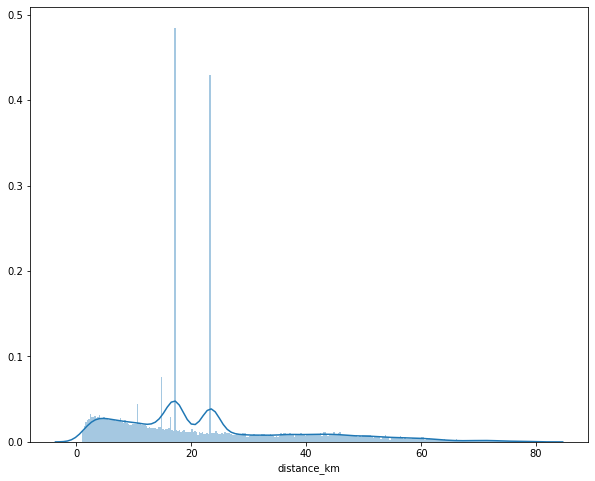

In [133]:
plt.figure(figsize = (10,8))
sns.distplot(data['distance_km'], bins=300)
plt.show()

Есть определенные группы поездок, по которым вообще нет данных по расстоянию и длительности. Заполним эти пропуски медианой по классу.

In [134]:
for offer_class in data['offer_class_group'].unique():
    data.loc[data['distance_km'].isnull(), 'distance_km'] = data[data['offer_class_group'] == offer_class]['distance_km'].median()

In [135]:
data.loc[data['duration_min'].isnull(), 'duration_min'] = data['distance_km'] / data['speed']

In [136]:
data.drop(['speed'], axis=1, inplace = True)

In [137]:
data.isnull().sum()

offer_gk             0
weekday_key          0
hour_key             0
driver_gk            0
order_gk             0
distance_km          0
duration_min         0
offer_class_group    0
ride_type_desc       0
driver_response      0
dist_unknown         0
dist_driver_order    0
dur_driver_order     0
dtype: int64

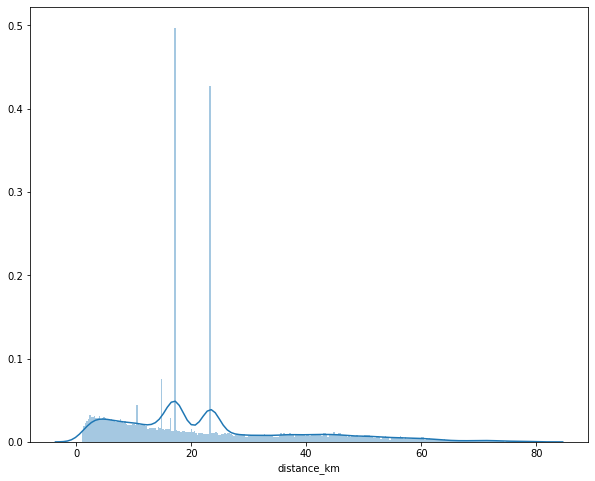

In [138]:
plt.figure(figsize = (10,8))
sns.distplot(data['distance_km'], bins=300)
plt.show()

Теперь все значения показателя дистанции и времени поездки заполнены, а также добавлены дополнительные параметры: поездки, по которым не было информации по дистанции, дистанция и время до клиента

Есть класс поездки Test. Всего 8 поездок. Возможно, тестируется новая услуга в такси. Предлагается удалить эти поездки.

In [139]:
data[data['offer_class_group']=='Test']

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dist_unknown,dist_driver_order,dur_driver_order
11880,849177,5,20,3763,83260,17.2985,23.050191,Test,SMB,0,1.0,0.955213,1.272818
30622,1122239,3,23,6290,493264,17.2985,21.248691,Test,SMB,0,1.0,0.600328,0.737416
43323,897797,5,20,591,83260,17.2985,23.050191,Test,SMB,1,1.0,3.166702,4.219620
53877,954625,1,18,172,203179,17.2985,22.928217,Test,SMB,1,1.0,0.729038,0.966300
64074,1039723,1,15,1916,357476,17.2985,23.387436,Test,SMB,1,1.0,1.354002,1.830600
81685,990065,2,14,3371,325838,17.2985,24.190192,Test,SMB,1,1.0,0.568536,0.795040
94430,159224,5,17,1126,392645,17.2985,26.933888,Test,SMB,1,1.0,0.446646,0.695431
95973,1060685,3,23,6302,493264,17.2985,21.248691,Test,SMB,1,1.0,0.491273,0.603458


In [140]:
data = data[data['offer_class_group']!='Test']

Далее добавим дополнительные признаки по данным категориальных столбцов

In [60]:
data.loc[data['weekday_key'].isin([6, 0]), 'weekends'] = 1
data.loc[~data['weekday_key'].isin([6, 0]), 'weekends'] = 0

data.loc[~data['weekday_key'].isin([6, 0]), 'weekdays'] = 1
data.loc[data['weekday_key'].isin([6, 0]), 'weekdays'] = 0

In [61]:
data.loc[data['hour_key'].isin([1,2,3,4,5,6]), 'nights'] = 1
data.loc[~data['hour_key'].isin([1,2,3,4,5,6]), 'nights'] = 0

data.loc[data['hour_key'].isin([7,8,9,10,11,12]), 'mornings'] = 1
data.loc[~data['hour_key'].isin([7,8,9,10,11,12]), 'mornings'] = 0

data.loc[data['hour_key'].isin([13,14,15,16,17,18]), 'days'] = 1
data.loc[~data['hour_key'].isin([13,14,15,16,17,18]), 'days'] = 0

data.loc[data['hour_key'].isin([19,20,21,22,23,0]), 'evenings'] = 1
data.loc[~data['hour_key'].isin([19,20,21,22,23,0]), 'evenings'] = 0

In [62]:
data.drop(['weekday_key', 'hour_key'], axis=1, inplace = True)

In [63]:
data.head()

,offer_gk,driver_gk,order_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dist_unknown,dist_driver_order,dur_driver_order,weekends,weekdays,nights,mornings,days,evenings
0,1105373,6080,174182,17.2985,23.050191,Economy,private,0,1.0,1.363473,1.816823,0.0,1.0,0.0,0.0,0.0,1.0
1,759733,6080,358774,18.8020,25.217000,Standard,private,1,0.0,3.414164,4.579032,0.0,1.0,0.0,0.0,1.0,0.0
2,416977,6080,866260,6.7470,9.800000,Economy,private,0,0.0,0.410128,0.595710,1.0,0.0,0.0,0.0,1.0,0.0
3,889660,6080,163522,17.2985,19.692001,Economy,private,1,1.0,0.647676,0.737291,0.0,1.0,1.0,0.0,0.0,0.0
4,1120055,6080,506710,12.3830,19.250000,Economy,private,1,0.0,1.062815,1.652200,0.0,1.0,0.0,0.0,1.0,0.0


In [64]:
data['offer_class_group'].value_counts()

Economy     47695
Standard    46654
Premium      1734
Delivery     1279
Kids          576
XL            435
VIP           215
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

In [65]:
offer_class_unique = list(data['offer_class_group'].unique())
for offer_class in offer_class_unique:
    data.loc[data['offer_class_group'] == offer_class, offer_class] = 1
    data.loc[data['offer_class_group'] != offer_class, offer_class] = 0

In [66]:
ride_type_unique = list(data['ride_type_desc'].unique())
for ride_type in ride_type_unique:
    data.loc[data['ride_type_desc'] == ride_type, ride_type] = 1
    data.loc[data['ride_type_desc'] != ride_type, ride_type] = 0

In [67]:
data.head()

,offer_gk,driver_gk,order_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dist_unknown,dist_driver_order,...,Kids,Delivery,Test,Premium,VIP,VIP+,private,business,affiliate,SMB
0,1105373,6080,174182,17.2985,23.050191,Economy,private,0,1.0,1.363473,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,759733,6080,358774,18.8020,25.217000,Standard,private,1,0.0,3.414164,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,416977,6080,866260,6.7470,9.800000,Economy,private,0,0.0,0.410128,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,889660,6080,163522,17.2985,19.692001,Economy,private,1,1.0,0.647676,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1120055,6080,506710,12.3830,19.250000,Economy,private,1,0.0,1.062815,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


И удалим категориальные столбцы и столбцы с идентификаторами поездки, заказа и водителя

In [68]:
data.drop(['offer_gk', 'driver_gk', 'order_gk', 'offer_class_group', 'ride_type_desc'], axis=1, inplace = True)

In [69]:
data.head()

,distance_km,duration_min,driver_response,dist_unknown,dist_driver_order,dur_driver_order,weekends,weekdays,nights,mornings,...,Kids,Delivery,Test,Premium,VIP,VIP+,private,business,affiliate,SMB
0,17.2985,23.050191,0,1.0,1.363473,1.816823,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,18.8020,25.217000,1,0.0,3.414164,4.579032,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,6.7470,9.800000,0,0.0,0.410128,0.595710,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,17.2985,19.692001,1,1.0,0.647676,0.737291,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,12.3830,19.250000,1,0.0,1.062815,1.652200,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Посмотрим на матрицу корреляций

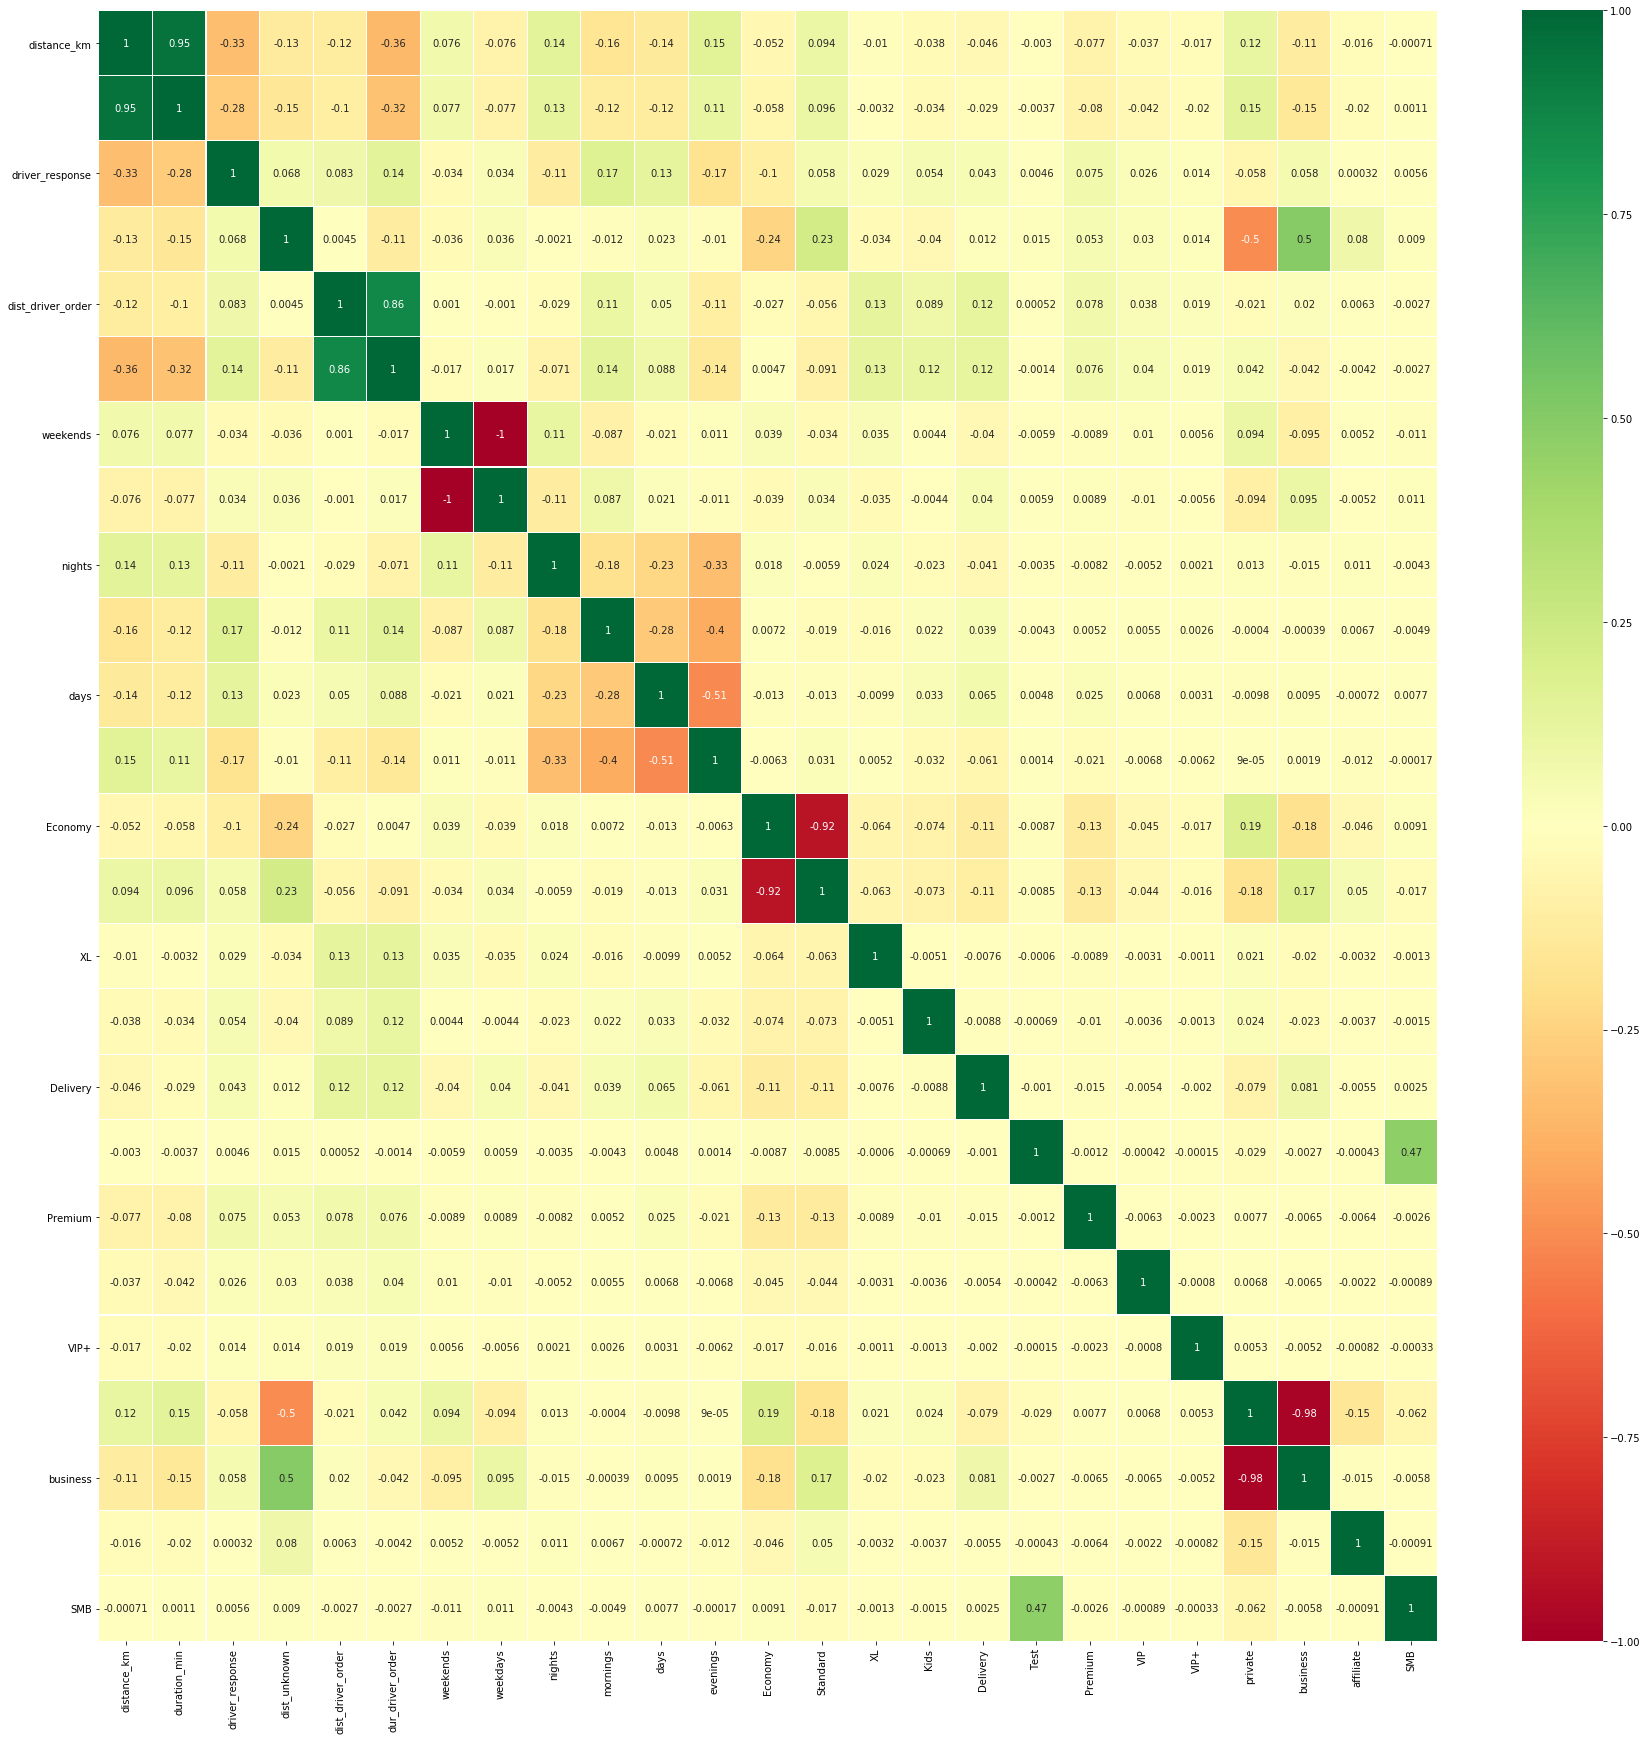

In [78]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.1)
fig=plt.gcf()
fig.set_size_inches(30, 30)
plt.show()

Так как целевой параметр driver_response очень слабо коррелирует с любым из других параметров, можно предположить, что нужно будет строить нелинейную модель

#### Приступим к обучению модели

In [70]:
X = data.drop(['driver_response'], axis=1)
y = data['driver_response']

Разделил датасет на все параметры, влияющие на целевой показатель, и сам целевой показатель

In [71]:
minmax_scaler = MinMaxScaler()
X = pd.DataFrame(minmax_scaler.fit_transform(X), columns=X.columns)

Произвел нормализацию данных с помощью MinMaxScaler.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Разделил данные на 80% тренировочных и на 20% тестовых

In [73]:
def train_model(columns):
    linear_model = LinearRegression()
    forest_model = RandomForestClassifier()
    xgb_model = XGBClassifier()

    linear_model.fit(X_train[columns], y_train)
    forest_model.fit(X_train[columns], y_train)
    xgb_model.fit(X_train[columns], y_train)
    prediction_1 = linear_model.predict(X_test[columns])
    prediction_2 = forest_model.predict(X_test[columns])
    prediction_3 = xgb_model.predict(X_test[columns])

    print(linear_model.score(X_test[columns], y_test))
    print(forest_model.score(X_test[columns], y_test))
    print(xgb_model.score(X_test[columns], y_test))

train_model(X.columns)

0.16590098034632983
0.6959695817490494
0.7185804816223067


Наилучший результат дает классификатор XGBoost. Далее проведем подбор параметров, с которым данный классификатор даст наиболее высокий результат. 

In [74]:
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None

model = MyXGBClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 71.86%
Thresh=0.000, n=24, Accuracy: 71.86%
Thresh=0.002, n=23, Accuracy: 71.86%
Thresh=0.004, n=22, Accuracy: 71.63%
Thresh=0.004, n=21, Accuracy: 71.84%
Thresh=0.006, n=20, Accuracy: 71.71%
Thresh=0.012, n=19, Accuracy: 71.76%
Thresh=0.015, n=18, Accuracy: 71.66%
Thresh=0.019, n=17, Accuracy: 71.67%
Thresh=0.020, n=16, Accuracy: 71.70%
Thresh=0.022, n=15, Accuracy: 71.93%
Thresh=0.022, n=14, Accuracy: 71.67%
Thresh=0.024, n=13, Accuracy: 71.69%
Thresh=0.037, n=12, Accuracy: 71.67%
Thresh=0.043, n=11, Accuracy: 71.58%
Thresh=0.045, n=10, Accuracy: 71.58%
Thresh=0.050, n=9, Accuracy: 71.55%
Thresh=0.052, n=8, Accuracy: 71.39%
Thresh=0.055, n=7, Accuracy: 71.61%
Thresh=0.059, n=6, Accuracy: 71.53%
Thresh=0.064, n=5, Accuracy: 67.01%
Thresh=0.065, n=4, Accuracy: 66.70%
Thresh=0.111, n=3, Accuracy: 65.33%
Thresh=0.134, n=2, Accuracy: 65.10%
Thresh=0.136, n=1, Accuracy: 64.49%


Наилучший результат (точность модели на тестовых данных 71.86%) получается при использовании всех 24 параметров.